In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [203]:
import pandas as pd 
from lifetimes.datasets import load_dataset

cdnow_transactions = load_dataset(
    'CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

cdnow_transactions.head()

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96
3,4,1,1997-12-12,2,26.48
4,21,2,1997-01-01,3,63.34


In [211]:
from lifetimes.utils import summary_data_from_transaction_data
rfm = summary_data_from_transaction_data(cdnow_transactions, 'customer_id', 'date', observation_period_end='1997-09-30', freq='W')
rfm.head(10)

,frequency,recency,T
customer_id,,,
4,2.0,30.0,39.0
18,0.0,0.0,39.0
21,1.0,2.0,39.0
50,0.0,0.0,39.0
60,0.0,0.0,35.0
71,0.0,0.0,39.0
86,0.0,0.0,39.0
111,6.0,29.0,39.0
112,1.0,5.0,39.0


In [205]:

from lifetimes import ParetoNBDFitter

pnbd = ParetoNBDFitter()
pnbd.fit(rfm['frequency'], rfm['recency'], rfm['T'])
print (pnbd)

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 14.56, beta: 13.88, r: 0.63, s: 0.57>


In [206]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal = calibration_and_holdout_data(
    cdnow_transactions, 
    customer_id_col='customer_id',
    datetime_col='date',
    calibration_period_end='1997-09-30',
    observation_period_end='1998-06-30',
    freq='W'
)

rfm_cal.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,2357.000000,2357.000000,2357.000000,2357.000000,2357.0
mean,0.940178,6.842597,32.985999,0.758591,39.0
std,1.835391,10.729357,3.346091,1.862830,0.0
min,0.000000,0.000000,27.000000,0.000000,39.0
25%,0.000000,0.000000,30.000000,0.000000,39.0
50%,0.000000,0.000000,33.000000,0.000000,39.0
75%,1.000000,12.000000,36.000000,1.000000,39.0
max,23.000000,39.000000,39.000000,26.000000,39.0


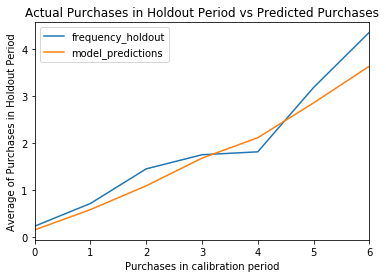

0.8571428571428571

In [207]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

pnbd.fit(rfm_cal['frequency_cal'], rfm_cal['recency_cal'], rfm_cal['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(pnbd, rfm_cal)
plt.show()
from sklearn.metrics import accuracy_score
#y_pred = [0.2, 0.5, 1, 1.75, 2, 3, 3.5]
#y_true = [0.25, 0.65, 1.45, 1.65, 1.75, 3, 4.5]
y_pred = [0,1,1,2,2,3,4]
y_true = [0,1,1,2,2,3,5]
accuracy_score(y_true, y_pred)

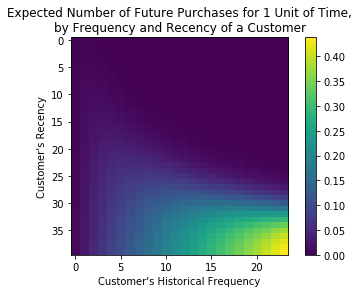

In [135]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(pnbd)
plt.show()

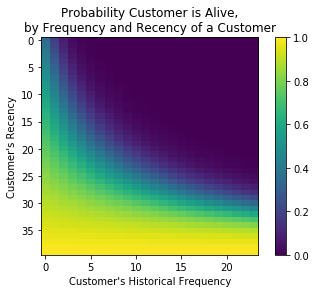

In [167]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(pnbd)
plt.show()

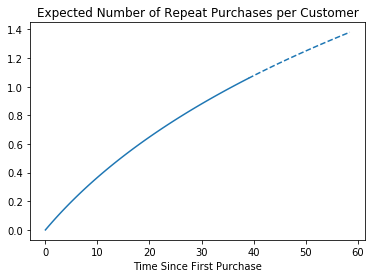

In [139]:
from lifetimes.plotting import plot_expected_repeat_purchases
plot_expected_repeat_purchases(pnbd)
plt.show()

In [210]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


In [143]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [144]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658609
2     18.911460
3     35.171004
4     35.171004
5     35.171004
6     71.462860
7     18.911460
8     35.171004
9     27.282402
10    35.171004
dtype: float64


In [145]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.252959133251984, Average profit: 35.07855179704026


In [185]:
pnbd.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    pnbd, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
   # discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1       0.717640
2      10.656698
3     630.799418
4     630.799418
5     630.799418
6       0.000031
7      10.656698
8     630.799418
9       0.794000
10    630.799418
Name: clv, dtype: float64


In [171]:
from lifetimes.utils import summary_data_from_transaction_data
rfm = summary_data_from_transaction_data(cdnow_transactions, 'customer_id', 'date', observation_period_end='1997-12-30', freq='W')
rfm.head()

,frequency,recency,T
customer_id,,,
4,3.0,49.0,52.0
18,0.0,0.0,52.0
21,1.0,2.0,52.0
50,0.0,0.0,52.0
60,0.0,0.0,48.0


In [172]:

from lifetimes import ParetoNBDFitter

pnbd = ParetoNBDFitter()
pnbd.fit(rfm['frequency'], rfm['recency'], rfm['T'])
print (pnbd)

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 14.47, beta: 10.13, r: 0.62, s: 0.43>


In [173]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal = calibration_and_holdout_data(
    cdnow_transactions, 
    customer_id_col='customer_id',
    datetime_col='date',
    calibration_period_end='1997-12-30',
    observation_period_end='1998-06-30',
    freq='W'
)

rfm_cal.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,2357.000000,2357.000000,2357.000000,2357.000000,2357.0
mean,1.231650,10.762410,45.985999,0.468392,26.0
std,2.377519,15.720162,3.346091,1.246199,0.0
min,0.000000,0.000000,40.000000,0.000000,26.0
25%,0.000000,0.000000,43.000000,0.000000,26.0
50%,0.000000,0.000000,46.000000,0.000000,26.0
75%,1.000000,22.000000,49.000000,0.000000,26.0
max,30.000000,52.000000,52.000000,17.000000,26.0


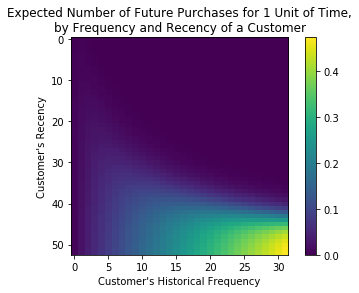

In [174]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(pnbd)
plt.show()

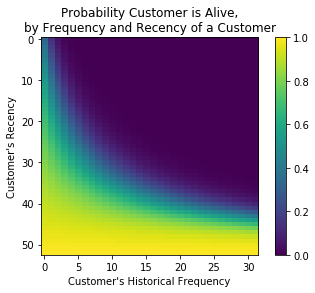

In [175]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(pnbd)
plt.show()

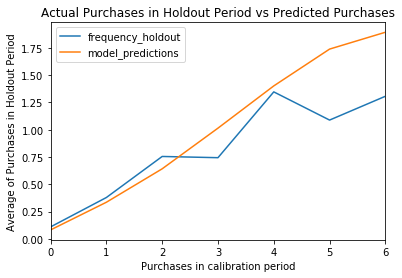

0.7142857142857143

In [199]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

pnbd.fit(rfm_cal['frequency_cal'], rfm_cal['recency_cal'], rfm_cal['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(pnbd, rfm_cal)
plt.show()
from sklearn.metrics import accuracy_score
#y_pred = [0.125, 0.25, 0.6, 1, 1.3, 1.75, 2]
#y_true = [0.130, 0.30, 0.75, 0.70, 1.30, 1.1, 1.25]
y_pred = [0,0,1,1,1,2,2]
y_true = [0,0,1,1,1,1,1]
accuracy_score(y_true, y_pred)



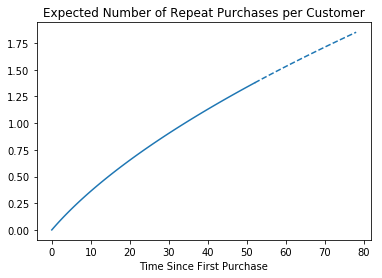

In [153]:
from lifetimes.plotting import plot_expected_repeat_purchases
plot_expected_repeat_purchases(pnbd)
plt.show()